In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from pathlib import Path

from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
num_labels = 3  # Effective, Adequate, Not Effective
model = AutoModelForSequenceClassification.from_pretrained('trainedModels/xlnet-base-cased', 
num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained('trainedModels/xlnet-base-cased')

trainer = Trainer(
    model=model,
)

# Check if MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Move model to the appropriate device
trainer.model.to(device)

# Tokenize input text
inputs = tokenizer("I think that the face is a natural landform because there is no life on Mars that we have descovered yet",
                    padding='max_length',
                    truncation=True,
                    max_length=128,
                    return_tensors="pt")

# Move inputs to the appropriate device
inputs = {key: value.to(device) for key, value in inputs.items()}

# Get prediction
with torch.no_grad():
    outputs = trainer.model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions).item()

# Display results
# probabilities = predictions[0].numpy()
probabilities = predictions[0].cpu().numpy()
labels = ["Effective", "Adequate", "Ineffective"]  # Define your class labels

print(f"**{labels[predicted_class]}**")

print("**Class Probabilities:**")
for class_name, prob in zip(labels, probabilities):
    print(f"{class_name}: {prob * 100:.2f}%")

**Adequate**
**Class Probabilities:**
Effective: 2.18%
Adequate: 83.29%
Ineffective: 14.53%


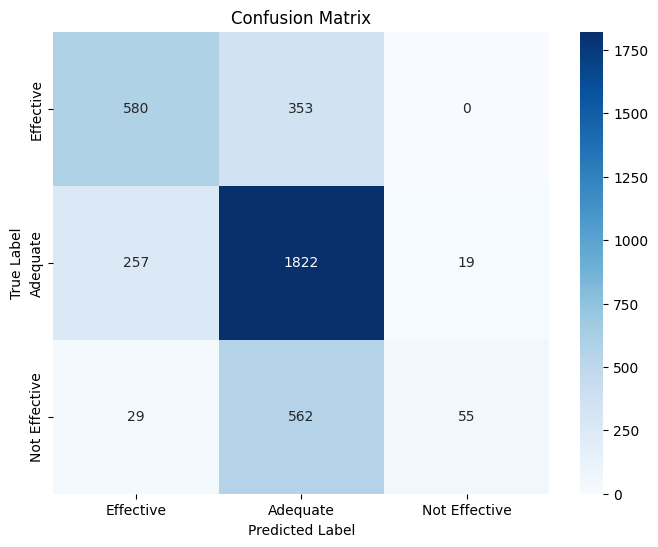

Classification Report:

               precision    recall  f1-score   support

    Effective       0.67      0.87      0.75      2098
     Adequate       0.67      0.62      0.64       933
Not Effective       0.74      0.09      0.15       646

     accuracy                           0.67      3677
    macro avg       0.69      0.53      0.52      3677
 weighted avg       0.68      0.67      0.62      3677



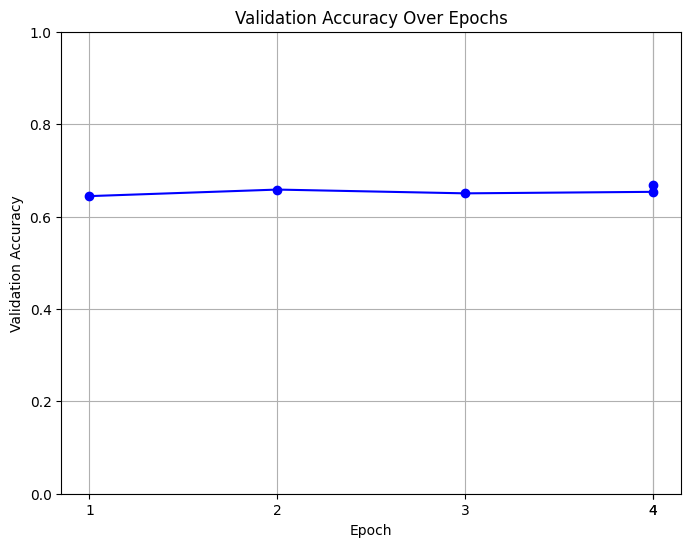

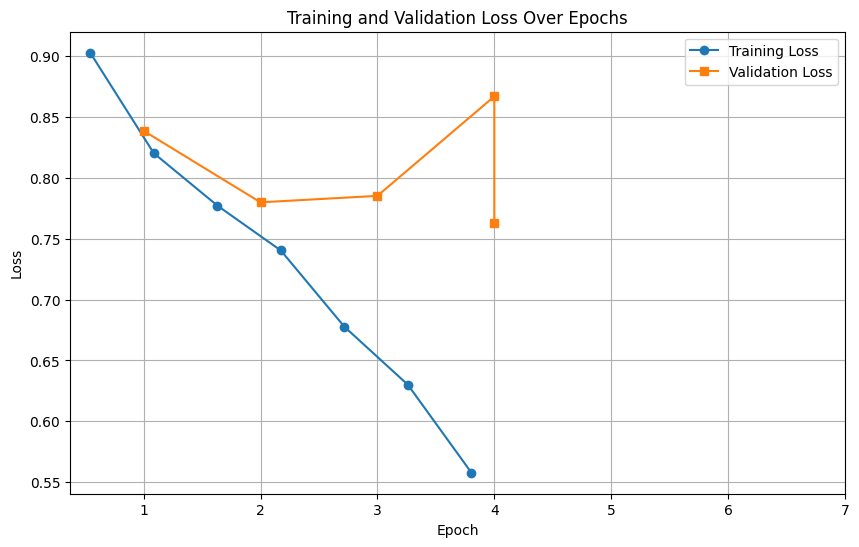

In [ ]:
# Ensure plots are displayed inline in Jupyter Notebooks
%matplotlib inline

predictions = []

with open(f'trainedModels/xlnet-base-cased/xlnet-base-cased-predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 2. Define Label Mapping
id_to_label = {0: "Effective", 1: "Adequate", 2: "Not Effective"}
predicted_labels_str = [id_to_label[label] for label in predicted_labels]
true_labels_str = [id_to_label[label] for label in true_labels]

# 3. Create Confusion Matrix
cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=["Effective", "Adequate", "Not Effective"])

# 4. Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Effective", "Adequate", "Not Effective"], 
            yticklabels=["Effective", "Adequate", "Not Effective"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Print Classification Report
print("Classification Report:\n")
print(classification_report(true_labels_str, predicted_labels_str, target_names=["Effective", "Adequate", "Not Effective"]))

# 6. Plot Accuracy Over Epochs
log_history = []

with open(f'trainedModels/xlnet-base-cased/xlnet-base-cased.pkl', 'rb') as f:
    log_history = pickle.load(f)

epochs = []
accuracies = []

for log in log_history:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xticks(epochs)
plt.ylim(0,1)
plt.grid(True)
plt.show()

# 7. (Optional) Plot Loss Over Epochs
train_losses = []
eval_losses = []
epochs_loss = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_losses.append(log['loss'])
        epochs_loss.append(log['epoch'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10,6))
plt.plot(epochs_loss, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, eval_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xticks(range(1, len(epochs_loss)+1))
plt.legend()
plt.grid(True)
plt.show()